# Project 5: Regression Tree, Cross Validation, Bagging, and Random Forest

## Setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

## Step 0: Define function_0 to normalize the dataset

In [2]:
# Function for Normalizing Dataset

# input_feature_norm = function_0(input_feature)

def function_0(input_feature):     
    
    # Normalizing input_features 
    input_feature_norm = input_feature / np.sqrt( np.sum(input_feature**2, axis=0) )
    
    return input_feature_norm

## Step 1: Define function_1 to caluculate MSE

In [3]:
# Function for Calculating MSE 

# mse = function_1(y_true, y_pred)

def function_1(y_true, y_pred):     
    
    error = y_true - y_pred
    mse = np.dot(error,error)/y_true.shape[0]
    
    return mse

## Step 2: Import carseats sale data from carseats_sale.csv

In [4]:
# Importing Car_seats_sale data
df = pd.read_csv (r'../data/carseats_sale.csv')  
print('Dataset Summary:')
print(f'\nCar Seats Sale dataset imported with following columns \n{list(df.columns)}')

# Numeric and categorical features
#col_num = [0, 1, 2, 3, 4, 6, 7] # features: 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education'
#col_cat = [5, 8, 9] # features: 'ShelveLoc', 'Urban', 'US'

col_num = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education']
col_cat = ['ShelveLoc', 'Urban', 'US']

for col in col_cat:
    df[col] = df[col].astype('category')
    

# create dummy variables
df_one_hot = df.copy()
df_one_hot = pd.get_dummies(df_one_hot,columns=col_cat)
print(list(df_one_hot.columns))

# Converting df to ordinal df: df_ord
df_ord = df.copy()


# ['ShelveLoc', 'Urban', 'US']
df_ord['ShelveLoc'] = 0*df_one_hot['ShelveLoc_Bad'] + 0.5*df_one_hot['ShelveLoc_Medium'] + 1*df_one_hot['ShelveLoc_Good']
df_ord['Urban'] = 0*df_one_hot['Urban_No'] + 1*df_one_hot['Urban_Yes']
df_ord['US'] = 0*df_one_hot['US_No'] + 1*df_one_hot['US_Yes']
df_ord.head()


# Converting string categories to numerical values
df_num = df.copy()
df_num['ShelveLoc'] = 1*np.where(df['ShelveLoc'] == 'Medium',1,0) + 2*np.where(df['ShelveLoc'] == 'Good',1,0)
df_num['Urban'] = np.where(df['Urban'] == 'Yes',1,0)
df_num['US'] = np.where(df['US'] == 'Yes',1,0)

# Converting Panda data to Numpy data
data = df_num.to_numpy()

# Spliting features and target

# features: 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc', 'Age', 'Education', 'Urban', 'US'
features = data[:,1:].astype(np.float32) 

# target: 'Sales'
sales = data[:,0].astype(np.float32)

# Splitting train and test data
train_features, test_features, train_target, test_target = \
train_test_split(features, sales, test_size=0.2, random_state=6)

# Dataset Summary
print(f'\nTrain dataset: train_features: {train_features.shape};  train_output: {train_target.shape}')
print(f'Test dataset: test_features {test_features.shape}; test_output: {test_target.shape}')
print('Dataset sample rows:')

Dataset Summary:

Car Seats Sale dataset imported with following columns 
['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'ShelveLoc', 'Age', 'Education', 'Urban', 'US']
['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education', 'ShelveLoc_Bad', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_No', 'Urban_Yes', 'US_No', 'US_Yes']

Train dataset: train_features: (320, 10);  train_output: (320,)
Test dataset: test_features (80, 10); test_output: (80,)
Dataset sample rows:


## Step 3: Implement Scikit Learn DecisionTreeRegressor() functions to fit regression tree to model and predict the output

In [5]:
# Fit regression tree to model

# Full depth tree
regr_full = DecisionTreeRegressor().fit(train_features, train_target)

# Pruned tree
depth = 4
regr_d = DecisionTreeRegressor(max_depth=depth)
regr_d.fit(train_features, train_target)

# Predict using fit trees
y_full = regr_full.predict(test_features)
y_d = regr_d.predict(test_features)

# MSE
mse_full = function_1(test_target,y_full)
mse_d = function_1(test_target,y_d)

# Print results
print('*****************************************************************************')
print(f'Step 3 | Regression Tree')
print('*****************************************************************************')
print(f'\n Full Tree: depth= {regr_full.get_depth()} => Test MSE=  {mse_full}')
print(f'\n Pruned Tree: depth= {regr_d.get_depth()} => Test MSE=  {mse_d}')

*****************************************************************************
Step 3 | Regression Tree
*****************************************************************************

 Full Tree: depth= 16 => Test MSE=  5.122262564051247

 Pruned Tree: depth= 4 => Test MSE=  4.717641963335727


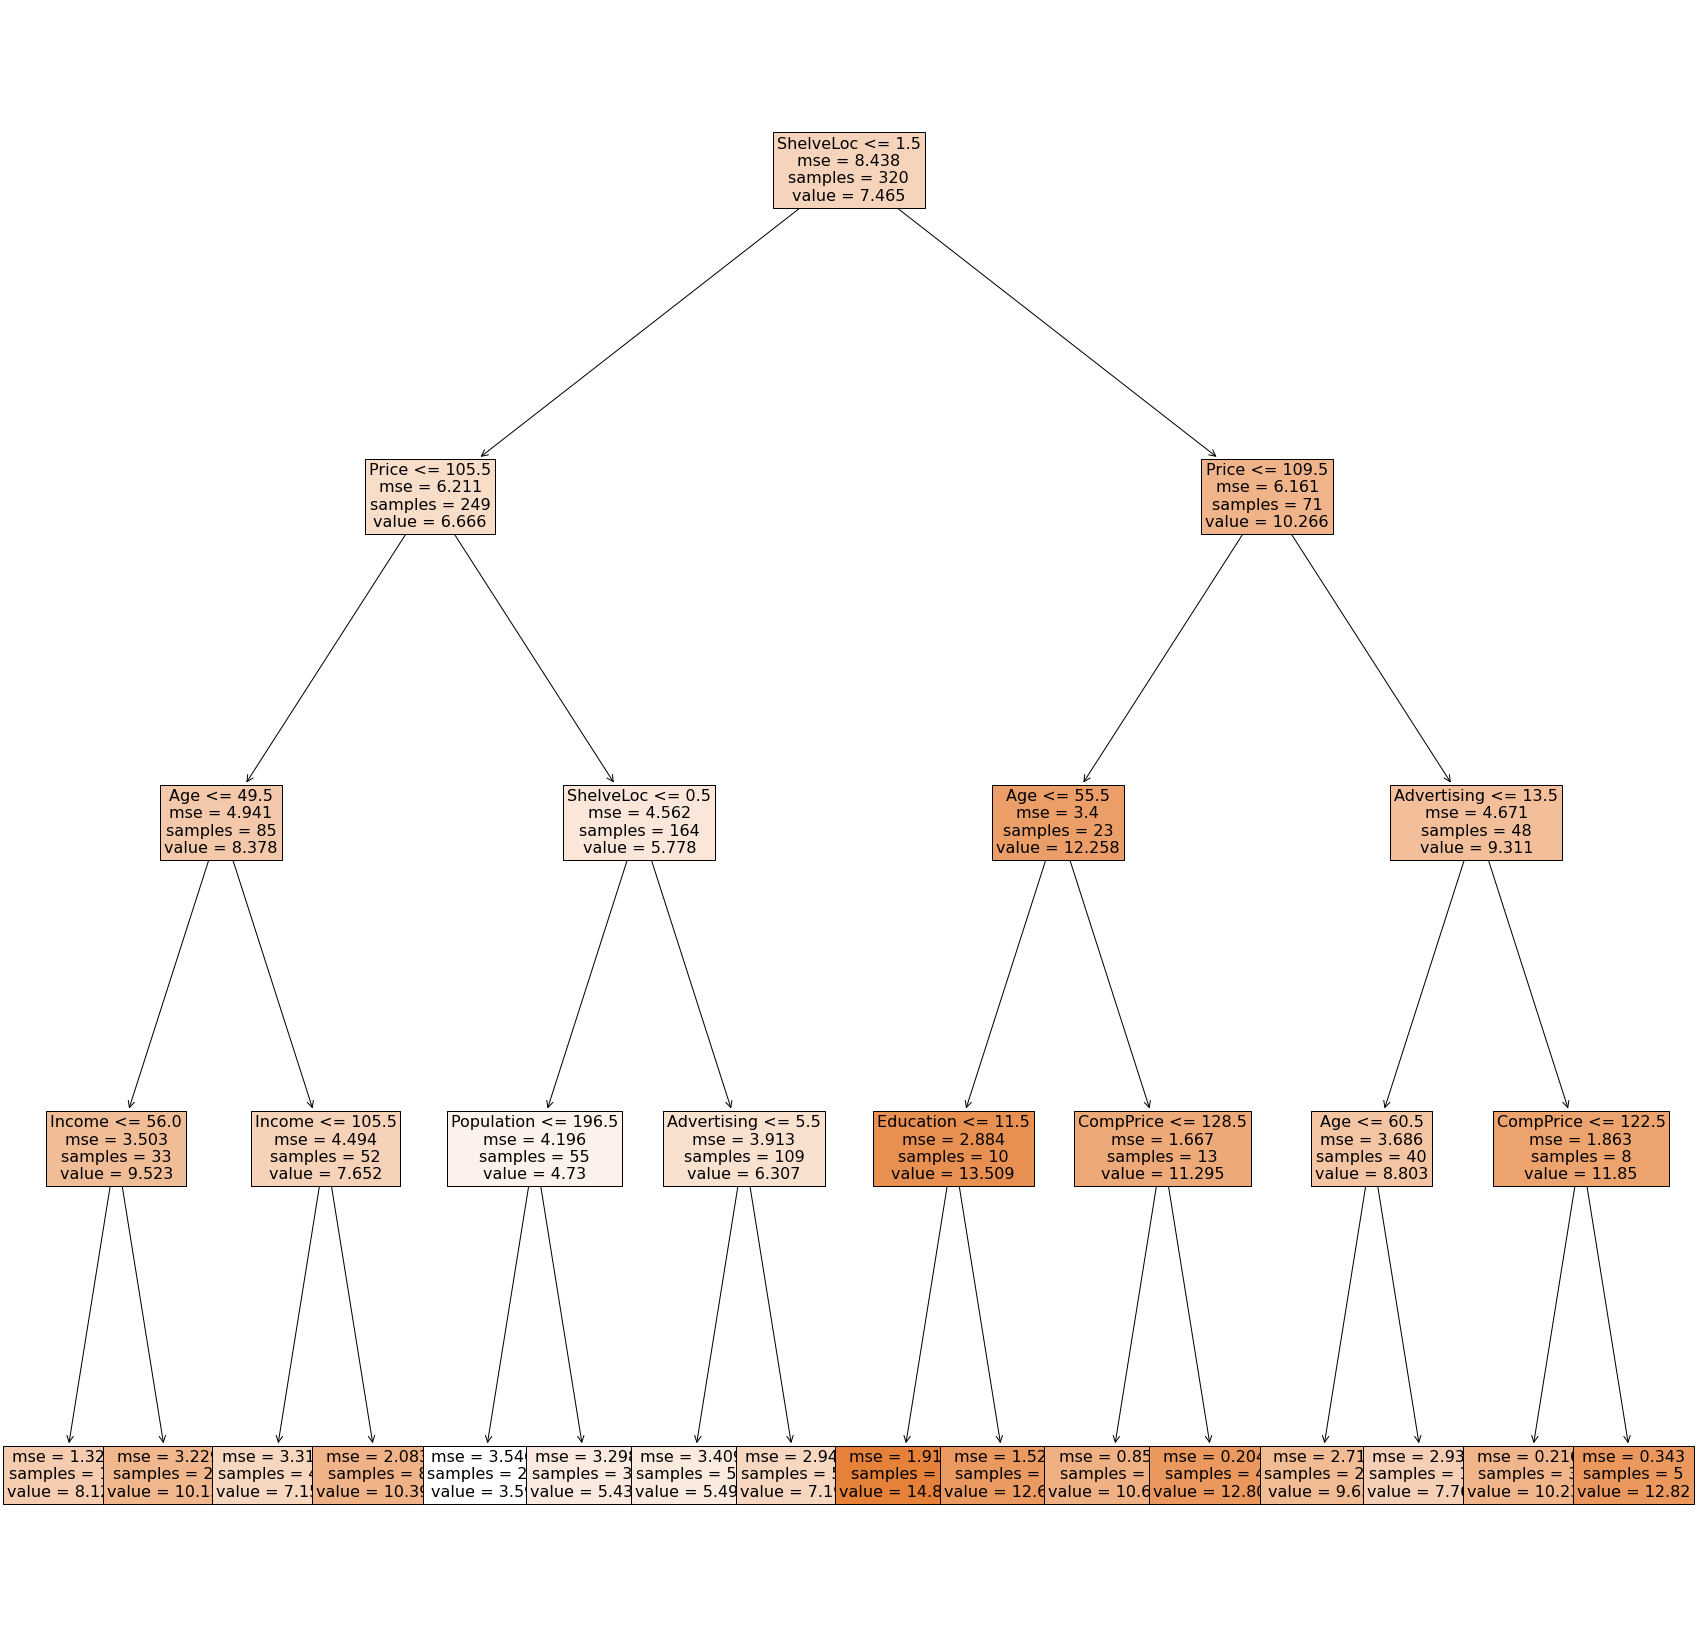

In [6]:
# Plot regression tree

feature_names = list(df.columns)[1:]
fig = plt.figure(figsize=(30,30))
plot_tree(regr_d, feature_names=feature_names, filled=True, fontsize=16)
plt.savefig("../results/regr_d.png", dpi=600)
plt.show()

## Step 4: Implement K-fold Cross Validation to find the depth for best test MSE (best_test_depth)

*****************************************************************************
Step 4 | 10-fold Cross Validation
*****************************************************************************
10-Fold Cross Validation: Best depth = 5 => Best Test MSE= 4.309923340710931


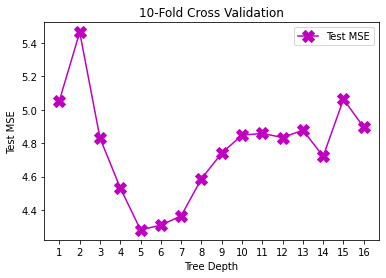

In [7]:
# K-fold Cross Validation
# Define constants
K = 10
N_train = train_features.shape[0]
D = 16
step = int(N_train/K)

train_idx_pool = np.arange(N_train)
depth_pool = np.arange(1,D+1)


validation_mse_k = []
test_mse_k = []
validation_mse = []
test_mse = []

# K-fold Cross Validation Loop
for depth in depth_pool:
    regr_depth = DecisionTreeRegressor(max_depth=depth)
    validation_mse_k = []
    test_mse_k = []

    for k in range(K):

        validation_idx = np.arange(k*step,(k+1)*step)
        train_idx = np.delete(train_idx_pool, validation_idx, 0)

        # Fit regr_depthession model to val. train data
        regr_depth.fit(train_features[train_idx,:], train_target[train_idx])

        # Predict val. & test y
        y_val = regr_depth.predict(train_features[validation_idx,:])
        y_test = regr_depth.predict(test_features)


        # Calculate & save val. & test mse
        validation_mse_k.append(function_1(train_target[validation_idx], y_val))
        test_mse_k.append(function_1(test_target, y_test))

    # Save val. & test mse for depth
    validation_mse.append(np.mean(np.array(validation_mse_k)))
    test_mse.append(np.mean(np.array(test_mse_k)))

# Cross validation results
best_test_depth = np.argmin(np.array(test_mse))+1

# Plot the results
print('*****************************************************************************')
print(f'Step 4 | 10-fold Cross Validation')
print('*****************************************************************************')
print(f'10-Fold Cross Validation: Best depth = {best_test_depth} => Best Test MSE= {test_mse[best_test_depth]}')

plt.figure()
plt.plot(range(D), test_mse, 'Xm-', markersize=12, label='Test MSE')
plt.xticks(range(D),range(1, D+1))
plt.xlabel("Tree Depth")
plt.ylabel("Test MSE")
plt.title("10-Fold Cross Validation")
plt.legend()
plt.savefig('../results/kfold.png',dpi=300)
plt.show()



## Step 5: Implement the bagging approach on regression trees with the best_test_depth

In [8]:
# Bagging for reg. trees with best_test_depth
regr_bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=best_test_depth))
regr_bag.fit(train_features, train_target)


# Predict
y_bag = regr_bag.predict(test_features)
mse_bag = function_1(test_target,y_bag)

# Print results
print('*****************************************************************************')
print(f'Step 5 | Bagging')
print('*****************************************************************************')
print(f'\n Bagging for Regression trees: depth: {best_test_depth} => Test MSE: {mse_bag}')

*****************************************************************************
Step 5 | Bagging
*****************************************************************************

 Bagging for Regression trees: depth: 5 => Test MSE: 2.785938217925861


## Step 6: Implement the random forest approach on regression trees with the best_test_depth

In [9]:
# Random forest for reg. trees with best_test_depth
regr_forest = RandomForestRegressor(max_depth=best_test_depth)
regr_forest.fit(train_features, train_target)

# Predict
y_forest = regr_forest.predict(test_features)
mse_forest = function_1(test_target,y_forest)


# Print results
print('*****************************************************************************')
print(f'Step 6 | Random Forest')
print('*****************************************************************************')
print(f'\n Random Forest: depth: {best_test_depth} => Test MSE: {mse_forest}')

*****************************************************************************
Step 6 | Random Forest
*****************************************************************************

 Random Forest: depth: 5 => Test MSE: 2.695309546080621
